# <h1>PREPROCESSING</h1>

## <h3>UPLOAD DATA</h3>

In [2]:
import pandas as pd
from binance.client import Client
from datetime import datetime, timedelta

api_key = 'Il7AIrG7k1CaXawPKVMSQAaiWEcYpIOswKzZIuObVPN3oO8JQEatLBHbkSzNk4ER'
secret_key = 'cEhGHkIuzgpoWmoiZuYrp8UEdNLb4Oh01pshY0xWOD3yOi0lruycCbdDm4t0Ap4H'

client = Client(api_key, secret_key)

start_date = "1 Jan, 2020"
end_date = "1 Dec, 2023"

# Convierte las cadenas de fecha en objetos datetime
start_date = datetime.strptime(start_date, '%d %b, %Y')
end_date = datetime.strptime(end_date, '%d %b, %Y')

# Obtener datos históricos de velas (candlesticks)
candlesticks = []
new_candles = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_5MINUTE, start_date.strftime('%d %b, %Y'), end_date.strftime('%d %b, %Y'), limit=1000)
candlesticks += new_candles



In [3]:
# Crear un DataFrame de Pandas
columns = ['open_time', 'Open', 'High', 'Low', 'Close', 'Volume', 'close_time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore']
df = pd.DataFrame(candlesticks, columns=columns)

In [4]:
# Convertir fechas de milisegundos a formato legible
df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')

# Asegúrate de que los datos estén ordenados por fecha
df.sort_values('open_time', inplace=True)

# Crear un índice temporal único (time_idx)
df['time_idx'] = range(len(df))

df['series_id'] = 'default_series'

In [5]:
import talib
import pandas as pd

# Asumiendo que df es tu DataFrame y ya tiene las columnas 'Open', 'High', 'Low', 'Close', y 'Volume'

# Calcula el Simple Moving Average (SMA) de los precios de cierre
df['SMA_10'] = talib.SMA(df['Close'], timeperiod=10)  # SMA de 10 periodos

# 1. EMA de periodos cortos:
df['EMA_3'] = talib.EMA(df['Close'], timeperiod=2)
df['EMA_5'] = talib.EMA(df['Close'], timeperiod=5)

# Calcula el Relative Strength Index (RSI)
df['RSI'] = talib.RSI(df['Close'], timeperiod=5)

# Calcula el MACD
df['MACD'], df['MACD_signal'], df['MACD_hist'] = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)

# Calcula el Average True Range (ATR)
df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)

# Calcula el On Balance Volume (OBV)
df['OBV'] = talib.OBV(df['Close'], df['Volume'])

# Patrones de velas japonesas
df['DOJI'] = talib.CDLDOJI(df['Open'], df['High'], df['Low'], df['Close'])
df['HAMMER'] = talib.CDLHAMMER(df['Open'], df['High'], df['Low'], df['Close'])
df['INV_HAMMER'] = talib.CDLINVERTEDHAMMER(df['Open'], df['High'], df['Low'], df['Close'])
df['SHOOTING_STAR'] = talib.CDLSHOOTINGSTAR(df['Open'], df['High'], df['Low'], df['Close'])
df['HANG_MAN'] = talib.CDLHANGINGMAN(df['Open'], df['High'], df['Low'], df['Close'])
df['ENGULFING'] = talib.CDLENGULFING(df['Open'], df['High'], df['Low'], df['Close'])

# Calcula las Bandas de Bollinger
df['upper_band'], df['middle_band'], df['lower_band'] = talib.BBANDS(df['Close'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)

## <h3>CLEAN DATA</h3>

In [6]:
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

In [7]:
# Eliminar filas donde todos los valores son NaN
df.dropna(inplace=True)

In [8]:
import pandas as pd
import numpy as np

# Assuming your DataFrame is named 'df'

# 1. Calculate the number of rows to remove:
current_rows = df.shape[0]
remainder = current_rows % 100
rows_to_remove = remainder

# 2. Perform random undersampling:
if rows_to_remove > 0:
    df = df.tail(current_rows - rows_to_remove)  # Set random_state for reproducibility

# Now your df.shape[0] should be a multiple of 100 
print(df.shape)

(411300, 32)


In [9]:
hola = round(df.shape[0] / 2)

df = df.tail(200000)

# <h1>MODEL</h1>

## <h3>IMPLEMENTATION</h3>

In [10]:

from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.tuner import Tuner
from pytorch_forecasting import TimeSeriesDataSet

d:\Programas\Anaconda\envs\myenv\lib\site-packages\pytorch_forecasting\models\base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [11]:
import numpy as np

# Crear un TimeSeriesDataSet
max_prediction_length = 3  # predecir la próxima vela
max_encoder_length = 60  # usar las últimas 60 velas para predecir
training_cutoff = np.datetime64("2022-12-18 17:35:00")
training = TimeSeriesDataSet(
	df[lambda x: x.open_time < training_cutoff],
    time_idx="time_idx",
    target="Close",
    group_ids=["series_id"],
    min_encoder_length=1,  # Ajusta según tu caso de uso
    max_encoder_length=5,  # Suponiendo que usas las últimas 60 velas para predecir
    min_prediction_length=1,
    max_prediction_length=1,  # Suponiendo que quieres predecir las siguientes 3 velas
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],
    time_varying_known_reals=["Open", "High", "Low", "Volume", "SMA_10", "EMA_3", "EMA_5", "RSI", "MACD", "ATR", "OBV", 
							  "DOJI", "HAMMER", "INV_HAMMER", "SHOOTING_STAR", "HANG_MAN", "ENGULFING", "upper_band", 
							  "middle_band", "lower_band"],
    time_varying_unknown_reals=["Close"],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [12]:
validation = TimeSeriesDataSet.from_dataset(training, df, min_prediction_idx=training.index.time.max() + 1, stop_randomization=True)
batch_size = 100  # Ajustar según las necesidades y la capacidad de tu máquina
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=2)

In [12]:
print(validation)

TimeSeriesDataSet[length=100018](
	time_idx='time_idx',
	target='Close',
	group_ids=['series_id'],
	weight=None,
	max_encoder_length=20,
	min_encoder_length=1,
	min_prediction_idx=311376,
	min_prediction_length=1,
	max_prediction_length=1,
	static_categoricals=[],
	static_reals=['encoder_length', 'Close_center', 'Close_scale'],
	time_varying_known_categoricals=[],
	time_varying_known_reals=['Open', 'High', 'Low', 'Volume', 'SMA_10', 'EMA_3', 'EMA_5', 'RSI', 'MACD', 'ATR', 'OBV', 'DOJI', 'HAMMER', 'INV_HAMMER', 'SHOOTING_STAR', 'HANG_MAN', 'ENGULFING', 'upper_band', 'middle_band', 'lower_band', 'relative_time_idx'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['Close'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={},
	add_relative_time_idx=True,
	add_target_scales=True,
	add_encoder_length=True,
	target_normalizer=GroupNormalizer(
	method='standard',
	groups=[],
	center=True,
	scale_by_group=False,
	transformation='relu',

## <h3>TRAINING THE MODEL</h3>

In [69]:
from pytorch_forecasting import TemporalFusionTransformer
import pytorch_forecasting
import lightning.pytorch as pl
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_lightning.loggers import TensorBoardLogger


# define trainer with early stopping
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=15, verbose=False, mode="min")
logger = TensorBoardLogger("marxIA", name="Transformer_prices")
trainer = pl.Trainer(
    max_epochs=200,
    accelerator="auto",
    gradient_clip_val=0.1,
    limit_train_batches=100,
    callbacks=[early_stop_callback],
	logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.0034124769651644265,
    hidden_size=90,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=45,
    loss=pytorch_forecasting.metrics.point.SMAPE(reduction='mean'),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="AdamW",
    reduce_on_plateau_patience=2,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\Programas\Anaconda\envs\myenv\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
d:\Programas\Anaconda\envs\myenv\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [18]:
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 550.7k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\Programas\Anaconda\envs\myenv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
d:\Programas\Anaconda\envs\myenv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
Finding best initial lr: 100%|██████████| 100/100 [00:17<00:00,  5.66it/s]
Learning rate set to 0.00036395187857636113
Restoring states from the checkpoint path at e:\VIDA PROFESIONAL\PROYECTS\marxIA\TrainModels\.lr_find_52064f1b-ad78-4740-a607-66b95169257b.ckpt
Restored all states from the checkpoint at e:\VIDA PROFESIONAL\PROYECTS\marxIA\TrainModels\.lr_find_52064f1b-ad78-4740-a607-66b95169257b.ckpt


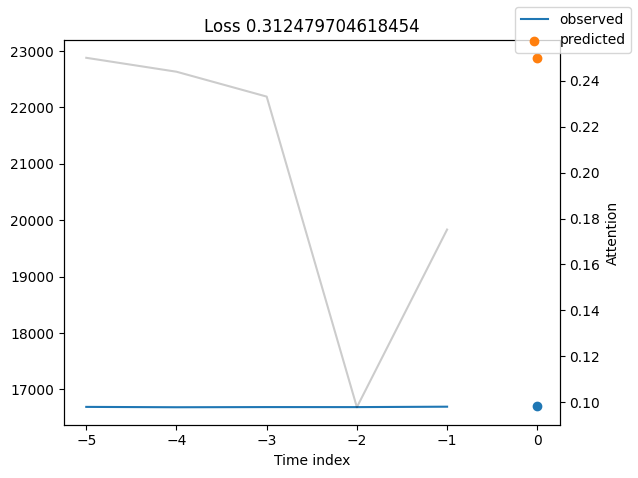

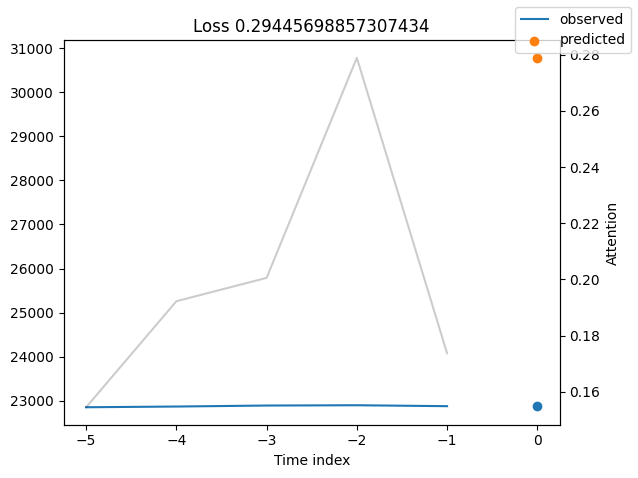

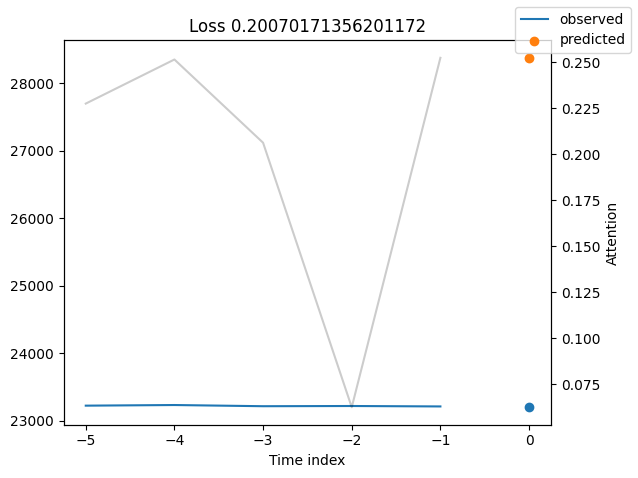

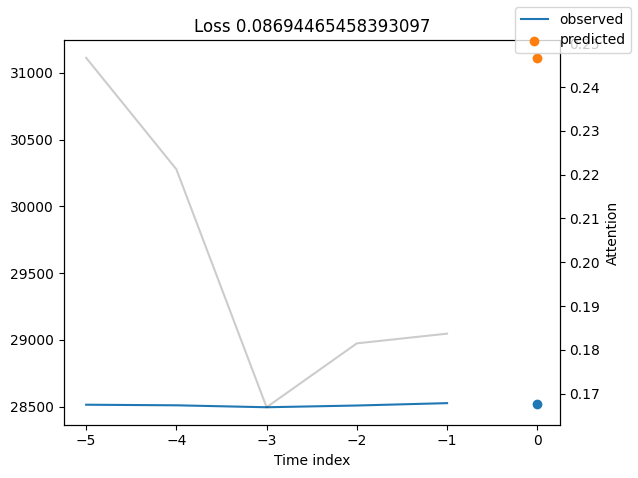

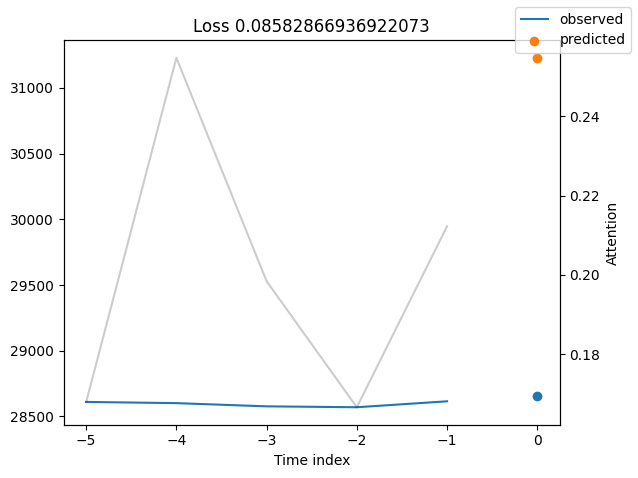

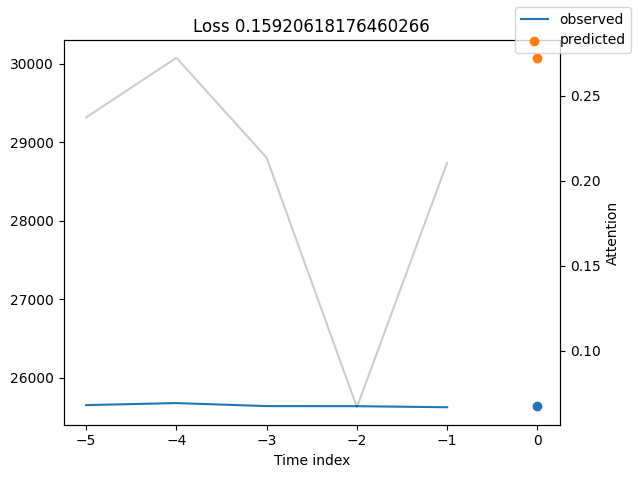

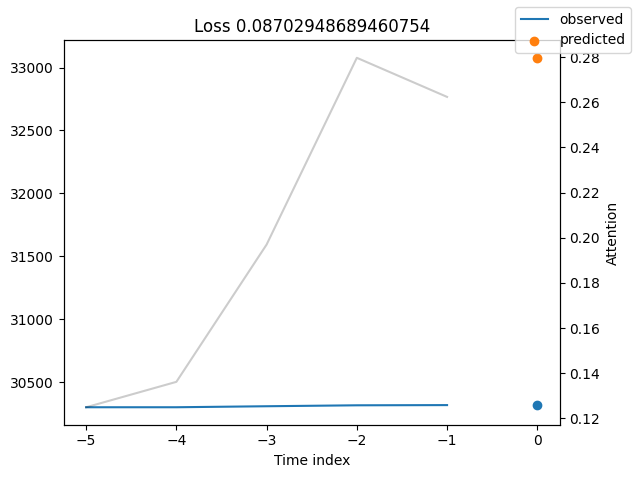

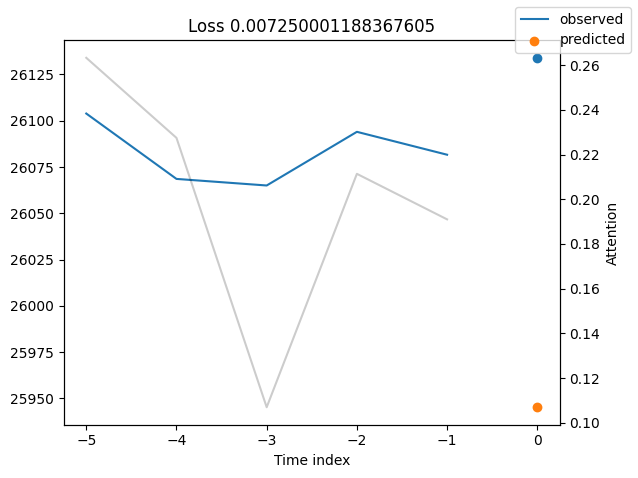

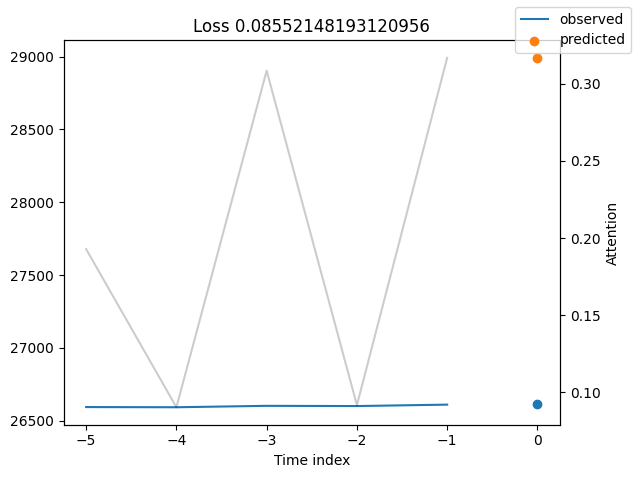

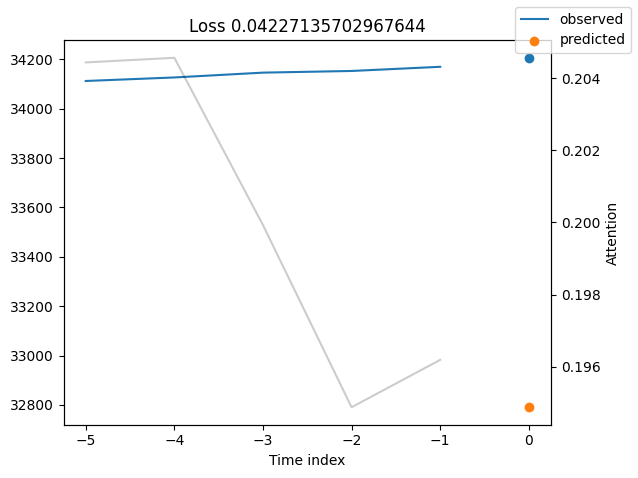

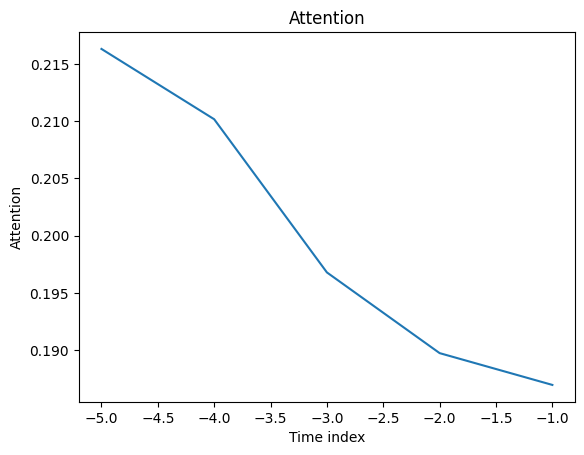

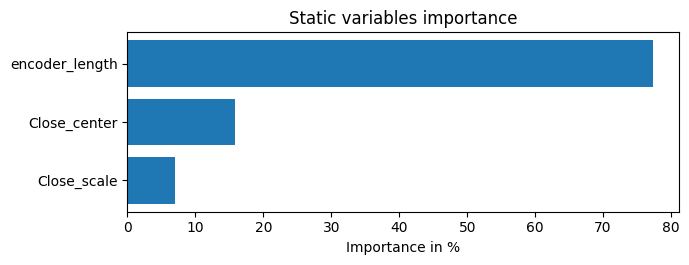

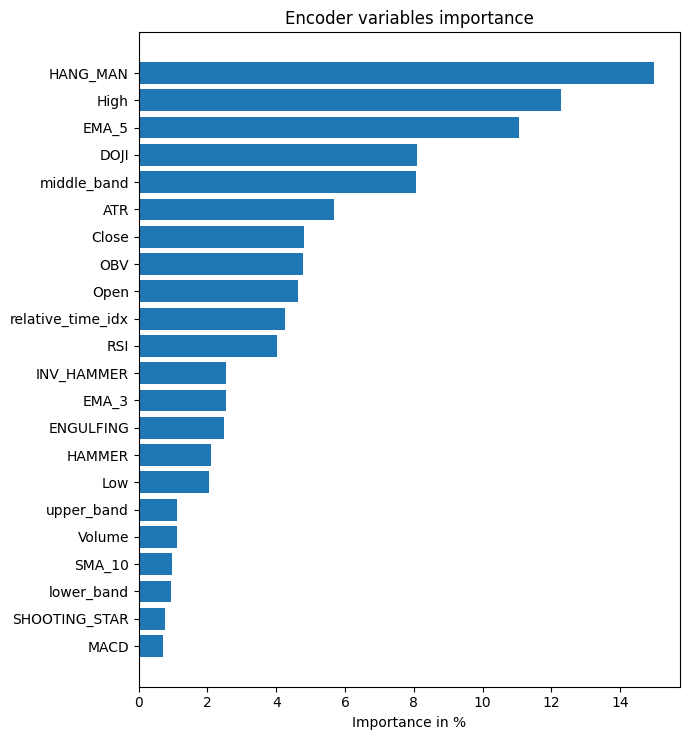

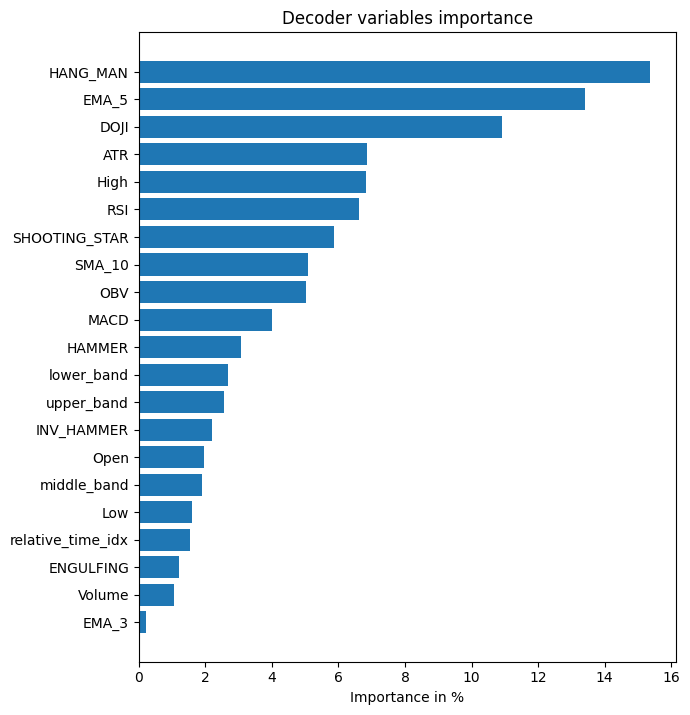

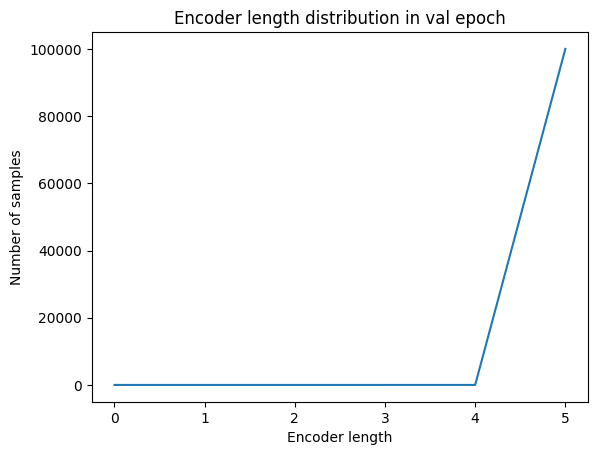

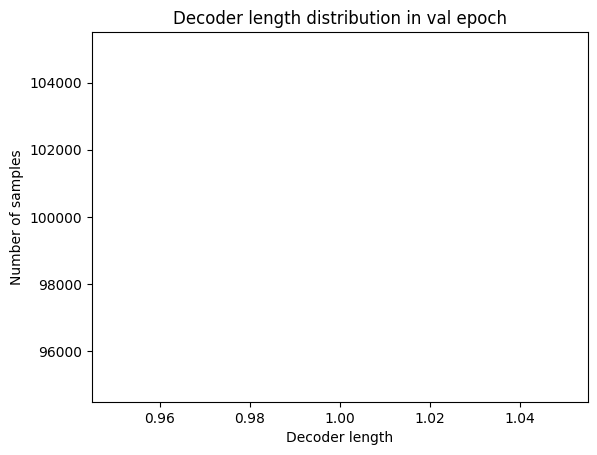

In [70]:
# find optimal learning rate (set limit_train_batches to 1.0 and log_interval = -1)
res = Tuner(trainer).lr_find(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, early_stop_threshold=1000.0, max_lr=0.3,
)

suggested learning rate: 0.0034124769651644265


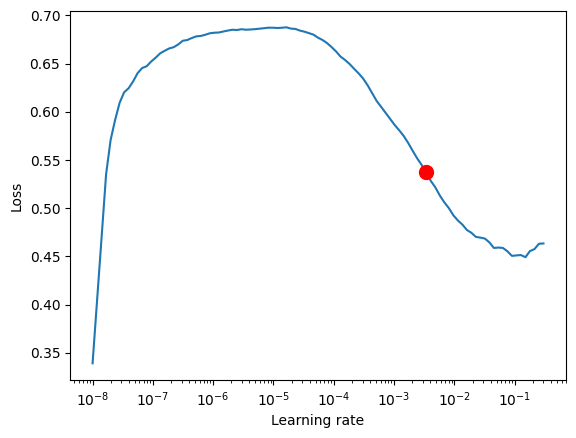

C:\Users\isrip\AppData\Local\Temp\ipykernel_16644\3284506899.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [ ]:
#Anterior

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

suggested learning rate: 0.00036395187857636113


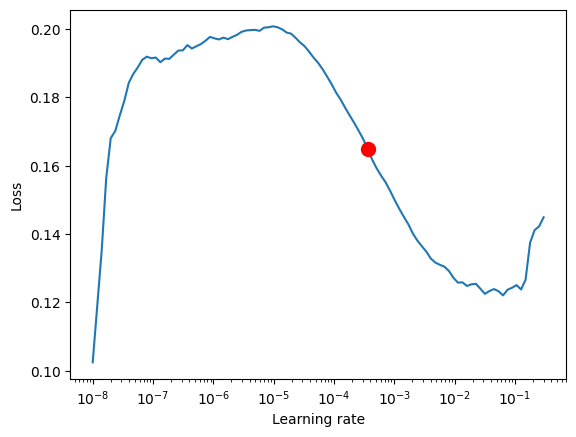

C:\Users\isrip\AppData\Local\Temp\ipykernel_16644\476125123.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [71]:
#NOW

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [72]:
# fit the model
trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | SMAPE                           | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 2.2 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 39.3 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 310 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 295 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 32.9 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 32.9 K
9  | static_context_initial_cell_lstm 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

d:\Programas\Anaconda\envs\myenv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


d:\Programas\Anaconda\envs\myenv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 43: 100%|██████████| 200/200 [01:45<00:00,  1.90it/s, v_num=71, train_loss_step=0.00155, val_loss=0.00131, train_loss_epoch=0.00132]  


## <h3>EVALUTION</h3>

In [1]:
from pytorch_forecasting import TemporalFusionTransformer

best_tft = TemporalFusionTransformer.load_from_checkpoint("E:\VIDA PROFESIONAL\PROYECTS\marxIA\TrainModels\\marxIA\Transformer_prices\\mejores_versiones_5m\\version_4\checkpoints\epoch=38-step=3900.ckpt")

# Imprime los hiperparámetros
print(best_tft.hparams)

d:\Programas\Anaconda\envs\myenv\lib\site-packages\pytorch_forecasting\models\base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
d:\Programas\Anaconda\envs\myenv\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
d:\Programas\Anaconda\envs\myenv\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


"attention_head_size":               4
"categorical_groups":                {}
"causal_attention":                  True
"dropout":                           0.1
"embedding_labels":                  {}
"embedding_paddings":                []
"embedding_sizes":                   {}
"hidden_continuous_size":            40
"hidden_continuous_sizes":           {}
"hidden_size":                       70
"learning_rate":                     0.0008607955795948924
"log_gradient_flow":                 False
"log_interval":                      10
"log_val_interval":                  10
"logging_metrics":                   ModuleList(
  (0): SMAPE()
  (1): MAE()
  (2): RMSE()
  (3): MAPE()
)
"loss":                              MAPE()
"lstm_layers":                       1
"max_encoder_length":                2
"monotone_constaints":               {}
"optimizer":                         AdamW
"optimizer_params":                  None
"output_size":                       1
"output_transformer":  

In [22]:
# calcualte mean absolute error on validation set
from pytorch_forecasting import MAE


predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="auto"))
MAE()(predictions.output, predictions.y)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\Programas\Anaconda\envs\myenv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


RuntimeError: The size of tensor a (100000) must match the size of tensor b (1000) at non-singleton dimension 0

In [52]:
import torch  # Assuming necessary imports

# ... (Your model definition and training code)

# Calculate predictions with raw output
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\Programas\Anaconda\envs\myenv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


In [56]:
# calcualte metric by which to display
from pytorch_forecasting import SMAPE

predictions = best_tft.predict(val_dataloader, return_y=True)

mean_losses = SMAPE(reduction="none")(predictions.output, predictions.y).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        raw_predictions.x,
        raw_predictions.output,
        idx=indices[idx],
        add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles),
    )

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\Programas\Anaconda\envs\myenv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


RuntimeError: The size of tensor a (100000) must match the size of tensor b (1000) at non-singleton dimension 0

In [ ]:
import torch

torch.save(best_tft.state_dict(), 'marxIA/Transfomer_prices/version1/marxIA_prices.pth')
